# Multi-Classification Machine Learning for Malware Analysis
## 9 Types of Malware in this dataset:
1. Ramnit         - RAT
2. Lollipop       - Adware
3. Kelihos_ver3   - RAT
4. Vundo          - Adware
5. Simda          - Botnet
6. Tracur         - Malicious Browser Plugin
7. Kelihos_ver1   - RAT
8. Obfuscator.ACY - Obfuscates other malware/information
9. Gatak          - RAT

## Game Plan:

- Look into creating more metrics to show off my model
- Improve the way I import data for the model
- Explain my code and solution in detail
- Port into the main program/script



## Imports

In [1]:
#pip install scikit-learn
#pip install seaborn
#pip install matplotlib
#pip install pandas
#pip install torch
#pip install torchvision
#pip install jupyterthemes

In [2]:
# All imports centralised here

import sys
import os
import re
import csv
import shutil
import heapq
import codecs
import json
from collections import Counter, OrderedDict, defaultdict
from pathlib import Path #Convert all directory accesses to this
from functools import reduce
import glob

import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn import svm
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pickle
import warnings


pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

## Functions

In [3]:
# Functions are all contained inside here

def createFullDirectory(mainDirectory,subDirectory):
    return str(mainDirectory+subDirectory)

def createFullPathToFile(fullDirectory, fileName):
    return str(fullDirectory+fileName)

def listFilesInDirectory(directoryContainingFiles):
    return glob.glob(directoryContainingFiles) 

def stripFilePathAndExtension(filePath, prefixToStrip, suffixToStrip):
    filePath = filePath.replace(prefixToStrip, "")
    filePath = filePath.replace(suffixToStrip, "")
    #return filePath
    return Path(filePath).stem

def replaceFilePathAndExtension(filePath, prefixToStrip, prefixToInsert, suffixToStrip, suffixToInsert):
    filePath = filePath.replace(prefixToStrip, prefixToInsert)
    filePath = filePath.replace(suffixToStrip, suffixToInsert)
    return filePath

def printDataFrame(dataframe):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(dataframe)

def zeroOutDataframe(dataframe):
    dataframe = dataframe.fillna(0)
    return dataframe

def countEntriesInDataframe(dataframe):
    return np.count_nonzero(dataframe)

def sortDictionary(dictionary):
    returnVal = sorted(dict(Counter(dictionary)).items(), key=lambda kv:
                 (kv[1], kv[0]))
    return returnVal

def fileNewlineIntoList(filePath):
    lineList = []
    with open(filePath) as openFile:
        for line in openFile:
            temp = line.strip()
            lineList.append(temp)
    return lineList

def stripNewlineAndWhitespace(textStringToStrip):
    textStringToStrip = textStringToStrip.replace("\t","")
    textStringToStrip = textStringToStrip.replace("\n","")
    textStringToStrip = textStringToStrip.replace(" ","")
    return textStringToStrip

def stripNewlineAndWhitespaceFromList(listToStrip):
    for i in range(0,len(listToStrip)):
        listToStrip[i] = listToStrip[i].replace("\t","")
        listToStrip[i] = listToStrip[i].replace("\n","")
        listToStrip[i] = listToStrip[i].replace(" ","")
    return listToStrip

def regexSearchFile(filePath, regexPattern):
    with open(filePath) as openFile:
        matches = re.findall(regexPattern, openFile.read())
    openFile.close()
    return matches

def cleanFileNameList(fileNameList,malwareClass, sortedDatasetDirectory): #NEED TO PORT THIS
    filePathToNameDict = {}
    for i in range(0, len(fileNameList)): 
        strippedFile = stripFilePathAndExtension(fileNameList[i], sortedDatasetDirectory+"/class-"+str(malwareClass)+"/", ".asm") #FIX THIS TO ALLOW FOR DIFFERENT CLASSES
        filePathToNameDict[strippedFile] = fileNameList[i]
        fileNameList[i] = strippedFile
    return fileNameList

def generateClassDataFrame(listColumnsToUse,listRowsToUse):
    return zeroOutDataframe(pd.DataFrame(columns=listColumnsToUse,index=listRowsToUse))

def moveFilesToClassFolders(backupFileList, fullFileNamesListFromCSV, unsortedDataset,sortedDataset): #Old and working before I tried the next version
    fullFileNamesListFromCSV.set_index("Id",inplace=True)
    for fileIndex in range(0,len(backupFileList)): # file is the full path to the file, fileClean is just the name of the file without extension
        fileClean = stripFilePathAndExtension(backupFileList[fileIndex],unsortedDataset,".asm")
        try:
            shutil.copyfile(backupFileList[fileIndex],sortedDataset+"class-"+str(fullFileNamesListFromCSV.loc[fileClean,"Class"])+"/"+str(fullFileNamesListFromCSV.loc[fileClean].name)+".asm")
        except:
            fileIndex = fileIndex + 1

def generateFilenameToDirectoryDict(fileDirectory):
    filePathToNameDict = {}
    for file in fileDirectory:
        filePathToNameDict[Path(file).stem] = file
    return filePathToNameDict

def populateMalwareDataframe(fileDirectoryTopLevel,instructionList):

    filePathToNameDict = generateFilenameToDirectoryDict(listFilesInDirectory(fileDirectoryTopLevel))
    dataFrame = zeroOutDataframe(pd.DataFrame(columns=instructionList,index=filePathToNameDict.keys()))

    for file in filePathToNameDict.keys(): # Go through every file in our directory
        fileDirectory = filePathToNameDict[file] # Convert using dict here
        instructionsForThisFile = stripNewlineAndWhitespaceFromList(regexSearchFile(fileDirectory,"(?:\t{3,7}       (?!db|dd)[a-zA-Z]{2,6} {1,})")) # cleaning and pulling instructions

        pandasSeriesTest = pd.Series(instructionsForThisFile).value_counts().index, pd.Series(instructionsForThisFile).value_counts().values # Counting each instruction up   
        for i in range(0, len(pandasSeriesTest[0])):
            dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
        
        #Optional cleaning options for my DF to merge dupe columns and group them up
        dataFrame = dataFrame.groupby(axis=1, level=0).sum() # Merges dupe columns
        #dataFrame = dataFrame.loc[:, (dataFrame != 0).any(axis=0)] # Removes columns with no values
    return dataFrame

def classDataFrameCompletion(instructionList,sortedDataset,classList,classInteger):
    print(sortedDataset+classList[classInteger-1]+"/*.asm")
    print(listFilesInDirectory(sortedDataset+classList[classInteger-1]+"/*.asm"))

    
    dataFrameInFunction = generateClassDataFrame(
        instructionList,      # This is the instruction list
        cleanFileNameList(    # This is the list of files
            listFilesInDirectory(sortedDataset+classList[classInteger-1]+"/*.asm"),  # This is the directory containing the files
            classInteger,
            sortedDataset))  #This is the malware class for cleanFileNameList
    
    dataFrameInFunction = populateMalwareDataframe(
                            sortedDataset+classList[classInteger-1]+"/*.asm",
                            instructionList)

    dataFrameInFunction = zeroOutDataframe(dataFrameInFunction)
    
    dataFrameInFunction.loc[~(dataFrameInFunction==0).all(axis=1)]
    
    dataFrameInFunction.insert(0,"class",classInteger)

    print(sortedDataset+classList[classInteger-1]+"/*.asm")

    return dataFrameInFunction

def removeNanValuesFromDataframe(dataframeToSanitise):
    dataframeToSanitise = dataframeToSanitise.replace(np.nan,0)
    return dataframeToSanitise

def normaliseData(dataframeToNormalise):
    #return (data -trainStats["mean"]) / trainStats['std'] #Works fine, experimenting with the OTHER
    #return data.div(data.sum(axis=1), axis=0)

    dataframeToNormalise = removeNanValuesFromDataframe(dataframeToNormalise)
    return dataframeToNormalise
    
def modelSVMClassifierCreate(cValue, kernelType):
    return svm.SVC(C=cValue, kernel=kernelType)
    
def svmModelFit(modelToFit,trainingDataframe, trainingDatasetLabels):
    return modelToFit.fit(trainingDataframe, trainingDatasetLabels)

def svmModelPredict(modelForPrediction, dataframeToPredictWith):
    return modelForPrediction.predict(dataframeToPredictWith)

def svmModelTrain(cValue, kernelType, trainingDataframe, trainingLabels):
    return svmModelFit(
                modelSVMClassifierCreate(
                    cValue, 
                    kernelType), 
                trainingDataframe, 
                trainingLabels)
     

def trainAndPredictModel(cValue, kernelType, trainingDataframe, trainingLabels):
    model = modelSVMClassifierCreate(cValue, kernelType)
    model = svmModelFit(model, trainingDataframe, trainingLabels)
    modelPrediction = svmModelPredict(model, trainingDataframe)

    print(kernelType+" training accuracy: ",metrics.accuracy_score(trainingLabels,modelPrediction))

    return modelPrediction, model

def createSVMConfusionMatrix(predictResults, fileClassList):

    for i in range(0, len(fileClassList)): fileClassList[i] = fileClassList[i][-1]#; fileClassList[i] = int(fileClassList[i])

    ax = plt.subplot()
    cm = confusion_matrix(predictResults,predictResults)

    ax.set_xlabel("Predicted Labels") # Doesn't work
    ax.set_ylabel("True Labels") # Doesn't work
    ax.set_title("Confusion Matrix - Linear")

    sns.heatmap(cm, annot=True, ax=ax, yticklabels=fileClassList, xticklabels=fileClassList); #Semicolon removes the annoying text above the graph

def classificationReportGenerateGraph(testLabels,svmTestDatasetPrediction):
    classificationReportDF = pd.DataFrame(classification_report(testLabels,svmTestDatasetPrediction,output_dict=True)).transpose()[:9]
    classificationReportF1Supp = classificationReportDF
    classificationReportF1Supp = classificationReportF1Supp[classificationReportF1Supp.columns[2:4]]
    classificationReportF1Supp["support"] = classificationReportF1Supp["support"].astype(int).div(100)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.bar(
        x=classificationReportF1Supp.index.values.tolist(), 
        height=classificationReportF1Supp["f1-score"], 
        width=0.5, 
        align='center')

    ax.bar(
        x=classificationReportF1Supp.index.values.tolist(), 
        height=classificationReportF1Supp["support"], 
        width=0.35, 
        align='center')

    f1ScoreBar = mpatches.Patch(color='blue', label="f1 score")
    supportScoreBar = mpatches.Patch(color='orange', label="support")
    ax.legend(handles=[f1ScoreBar, supportScoreBar],bbox_to_anchor=(0.5, -0.055), loc="upper center",ncol=2)
    ax.set_title("A graph demonstrating the relationship between F1 scores and support")

    plt.tight_layout()
    plt.show()

def permutationImportanceGraphPlot(model, normalisedTrainDF, trainLabels, finalDF):
    permutationImportance = permutation_importance(model, normalisedTrainDF, trainLabels)
    featuresList = np.array(list(normalisedTrainDF.columns))
    sortedIDX = permutationImportance.importances_mean.argsort()
    mostImportantIndexesPermutation = [list(permutationImportance.importances_mean[sortedIDX]).index(i) for i in heapq.nlargest(30, permutationImportance.importances_mean[sortedIDX])]

    ### Showing the largest features
    newFeaturesList = []
    newPermutationImportanceList = []

    for i in mostImportantIndexesPermutation[::-1]:
        newFeaturesList.append(featuresList[sortedIDX][i])
        newPermutationImportanceList.append(permutationImportance.importances_mean[sortedIDX][i])

    occurancesQuantity={}
    for i in newFeaturesList[::-1]:
        occurancesQuantity.update({i:str(int(finalDF[i].mean()))})


    from sklearn import preprocessing
    plt.subplot(1, 2, 1)
    plt.barh(newFeaturesList, newPermutationImportanceList);
    plt.xlabel("Permutation Importance/Feature");
    plt.margins(x=0)
    plt.xticks([0,0.1,0.2,0.3,0.4,0.5],["0","0.2","0.4","0.6","0.8","1"])

    plt.subplot(1, 2, 2)
    plt.barh(list(occurancesQuantity.keys())[::-1], preprocessing.minmax_scale(list(occurancesQuantity.values())[::-1],feature_range=(0,0.5)));
    plt.xlabel("Mean Relative occurances/Feature");
    plt.xticks([0,0.1,0.2,0.3,0.4,0.5],["0","0.2","0.4","0.6","0.8","1"])
    plt.margins(x=0)
    plt.tight_layout()

def setupSanitisedDatasetSubset(sortedDataset, classList):
    for fileClass in classList:
        directory = str(sortedDataset+fileClass+"/*")
        fileList = listFilesInDirectory(directory) #glob.glob(directory)

        print(fileClass)
        print(len(fileList))

        i = 0
        for i in range(0,len(fileList)):
            if(i >= 250):
                os.remove(fileList[i])
        print(len(listFilesInDirectory(sortedDataset+classList[0]+"/*.asm")))

def pickleSaveModel(model, modelSaveLocation):
    pickle.dump(model, open(modelSaveLocation, "wb"))

def pickleLoadModel(modelLoadLocation):
    return pickle.load(open(modelLoadLocation,"rb"))

def collectTrainingData(workingDirectory, sortedDataset, classList):
    #instructionList = fileNewlineIntoList(workingDirectory+"instructionListComplete.txt")
    instructionList = fileNewlineIntoList(workingDirectory+"instructionListSubset.txt")
    instructionList = [instruction.lower() for instruction in instructionList] # Making all instructions lowercase
    dataframeClassOne = classDataFrameCompletion(instructionList, sortedDataset, classList, 1)
    dataframeClassTwo = classDataFrameCompletion(instructionList, sortedDataset, classList, 2)
    dataframeClassThree = classDataFrameCompletion(instructionList, sortedDataset, classList, 3)
    dataframeClassFour = classDataFrameCompletion(instructionList, sortedDataset, classList, 4)
    dataframeClassFive = classDataFrameCompletion(instructionList, sortedDataset, classList, 5)
    dataframeClassSix = classDataFrameCompletion(instructionList, sortedDataset, classList, 6)
    dataframeClassSeven = classDataFrameCompletion(instructionList, sortedDataset, classList, 7)
    dataframeClassEight = classDataFrameCompletion(instructionList, sortedDataset, classList, 8)
    dataframeClassNine = classDataFrameCompletion(instructionList, sortedDataset, classList, 9)

    return [dataframeClassOne,dataframeClassTwo,dataframeClassThree,dataframeClassFour,dataframeClassFive,dataframeClassSix,dataframeClassSeven,dataframeClassEight,dataframeClassNine]

def collectCustomTrainingData(workingDirectory, customTrainingFilesList):
    instructionList = fileNewlineIntoList(workingDirectory+"instructionListSubset.txt")
    instructionList = [instruction.lower() for instruction in instructionList]

    classifyDF = zeroOutDataframe(pd.DataFrame(columns=instructionList,index=list(customTrainingFilesList)))

    

    return classifyDF


def constructFinalDF(dataframesList):
    finalDF = pd.concat(dataframesList).drop_duplicates()
    finalDF = zeroOutDataframe(finalDF)
    finalDF.loc[~(finalDF==0).all(axis=1)]
    finalDF = finalDF.loc[:, (finalDF != 0).any(axis=0)] # Removes columns with no values
    finalDF = finalDF.sample(frac=1)
    finalDF.info()
    return finalDF

def createTrainTestValidSplits(finalDF):
    trainDF, testAndValidDF = train_test_split(finalDF, test_size=0.4)
    testDF, validDF = train_test_split(testAndValidDF, test_size=0.5)

    print(f"Training Dataset rows and columns: {trainDF.shape}")
    print(f"Test Dataset rows and columns: {testDF.shape}")
    print(f"Validation Dataset rows and columns: {validDF.shape}")
    return trainDF, validDF, testDF

def writeTrainingStats(trainDF, writeLocation):
    trainStats = trainDF.describe()
    trainStats.pop("class")
    trainStats = trainStats.transpose()
    trainStats.to_csv(writeLocation)

def createExamplePrediction(normalisedTestDF, model):
    exampleSubsetDF = normalisedTestDF[:10]
    exampleResult = model.predict(exampleSubsetDF)
    dataFrameExampleResult = pd.Series(list(exampleSubsetDF.index),index=exampleResult)
    dataFrameExampleResult.head(10)
    
def createSetLabels(dataframe, nameOfDataframe):
    createdLabels = dataframe.pop("class")
    print(nameOfDataframe+" data rows: "+str(len(createdLabels)))
    return createdLabels, dataframe

def stripInstructions(filePath):
    pattern = re.compile("(?:^[a-zA-Z]{2,6}\s)")

    matches = []

    for line in enumerate(open(filePath)):
        for match in re.finditer(pattern, line):
            currentMatch = match.group()
            currentMatch = currentMatch.strip()
            matches.append(currentMatch)

## Defining Directories and required structures

In [4]:
# Directory structures are defined here

workingDirectory = os.getcwd()
workingDirectory = workingDirectory+"/"
baseDirectory = workingDirectory+"data/"

classList = ["class-1","class-2","class-3","class-4","class-5","class-6","class-7","class-8","class-9"]
unsortedDataset = createFullDirectory(baseDirectory,"dataset-training-full-sanitised/")
sortedDataset = createFullDirectory(baseDirectory,"dataset-training-subset-sorted/")
customDataset = createFullDirectory(baseDirectory,"custom-dataset-sanitised/")
classifyFilesDataset = createFullDirectory(baseDirectory,"filesToClassify/")

## Pulling the files from the dataset into the class folders

In [5]:
# Moving files from the santised but unsorted folder into the sanitised and sorted folder

#moveFilesToClassFolders(listFilesInDirectory(unsortedDataset+"*"),pd.read_csv(baseDirectory+"trainLabels.csv"),unsortedDataset,sortedDataset)

### Making sure there are less than 250 files in each class

In [6]:
# Deleting all but 250 files in each class

#shutil.copytree(customDataset,sortedDataset)

setupSanitisedDatasetSubset(sortedDataset, classList)


class-1
251
250
class-2
252
250
class-3
251
250
class-4
251
250
class-5
1558
250
class-6
250
250
class-7
250
250
class-8
250
250
class-9
250
250


## Creating the Pandas DataFrame for the malware classes

In [7]:
# Creating a Dataframe for each of the classes

dataframesList = collectTrainingData(workingDirectory,sortedDataset, classList)


/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-1/*.asm
['/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-1/bAPu2lGC9t5NF0EvZU7H.asm', '/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-1/K3OIpSMVl9DEH1qY2Fyn.asm', '/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-1/Jved4Yh29n1SIkfwZW7j.asm', '/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-1/2ZPDI3tv7UdhkfRWu54L.asm', '/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-1/EmVYF0ZrIBWCGL5168XH.asm', '/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-1/GRYhfsPiy72KcE8VaeqF.asm', '/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-1/4xli1n8H7ez9aR5vbPSN.asm', '/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/cla

In [8]:
# Constructing the Final Dataframe

finalDF = constructFinalDF(dataframesList)

<class 'pandas.core.frame.DataFrame'>
Index: 1766 entries, k9Vp4RQczHiGXIJ10qMf to hjdkwfeHXnWoUsJPY2y3
Columns: 350 entries, class to VxDJmp
dtypes: float64(349), int64(1)
memory usage: 4.7+ MB


## Splitting the data into train+test sets

In [9]:
# Dividing up the dataset into train, validate and test sets

trainDF, validDF, testDF = createTrainTestValidSplits(finalDF)

Training Dataset rows and columns: (1059, 350)
Test Dataset rows and columns: (353, 350)
Validation Dataset rows and columns: (354, 350)


## Training Stats

In [10]:
# Creating training stats based on the trainDF dataset

###writeTrainingStats(trainDF, "/home/eddy/traindata.csv")

In [11]:
# Creating Training, Validation and Testing Labels and printing the length of each

trainLabels, trainDF = createSetLabels(trainDF, "Train data")
validLabels, validDF = createSetLabels(validDF, "Valid data")
testLabels, testDF = createSetLabels(testDF, "Test data")

Train data data rows: 1059
Valid data data rows: 354
Test data data rows: 353


## Data Normalisation/Scaling

In [12]:
# Normalisation Functions happen here

normalisedTrainDF = removeNanValuesFromDataframe(normaliseData(trainDF))
normalisedValidDF = removeNanValuesFromDataframe(normaliseData(validDF))
normalisedTestDF = removeNanValuesFromDataframe(normaliseData(testDF))

#normalisedTrainDF.head(10)

## Training the model and creating a small prediction for testing

In [13]:
# SVM Classifier Object is Created

#createExamplePrediction(normalisedTestDF, model)

svmLinearModelPrediction, model = trainAndPredictModel(1.5, "linear", normalisedTrainDF, trainLabels)
#print("Linear Train Accuracy: ",metrics.accuracy_score(trainLabels,svmLinearModelPrediction))
svmValidationDatasetPrediction = svmModelPredict(model, normalisedValidDF)
print("Linear Validation Accuracy: ",metrics.accuracy_score(validLabels,svmValidationDatasetPrediction))
svmTestDatasetPrediction = svmModelPredict(model, normalisedTestDF)
print("Linear Test Accuracy: ",metrics.accuracy_score(testLabels,svmTestDatasetPrediction))


svmPolyModelPrediction, modelPoly = trainAndPredictModel(1.5, "poly", normalisedTrainDF, trainLabels)

svmRBFModelPrediction, modelRBF = trainAndPredictModel(1.5, "rbf", normalisedTrainDF, trainLabels)

svmSigmoidModelPrediction, modelSig = trainAndPredictModel(1.5, "sigmoid", normalisedTrainDF, trainLabels)


linear training accuracy:  0.9933899905571294
Linear Validation Accuracy:  0.940677966101695
Linear Test Accuracy:  0.9206798866855525
poly training accuracy:  0.21813031161473087
rbf training accuracy:  0.4183191690273843
sigmoid training accuracy:  0.23418319169027385


## Confusion Matrix for the model

In [14]:
# Classification Report Details
print(classification_report(testLabels,svmTestDatasetPrediction))

              precision    recall  f1-score   support

           1       0.89      0.74      0.81        46
           2       0.84      0.94      0.89        50
           3       0.98      0.98      0.98        49
           4       0.98      0.94      0.96        47
           5       0.00      0.00      0.00         1
           6       0.79      1.00      0.88        11
           7       0.92      0.96      0.94        47
           8       0.95      0.91      0.93        58
           9       0.98      0.98      0.98        44

    accuracy                           0.92       353
   macro avg       0.81      0.83      0.82       353
weighted avg       0.93      0.92      0.92       353



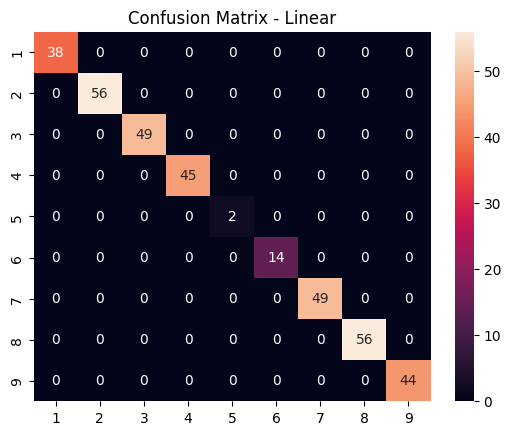

In [15]:
# Confusion Matrix Plotted and Printed Here

createSVMConfusionMatrix(svmTestDatasetPrediction,classList)

## Permutation importance stats for the model's weighting of features

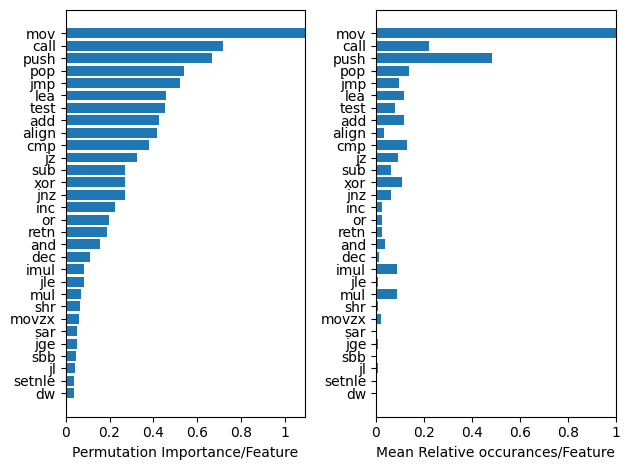

In [17]:
# Permutation Importance Graphs Plotted and Printed Here - Compare these with how many files these instructions actually occur in

permutationImportanceGraphPlot(model, normalisedTrainDF, trainLabels, finalDF)

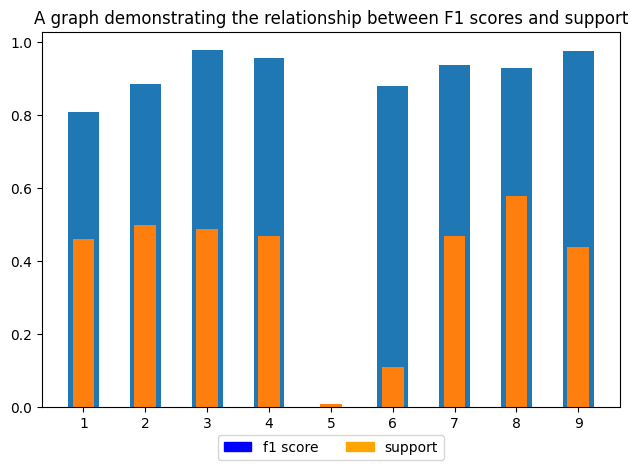

In [18]:
# Raw Classification Report stats graphed out here

classificationReportGenerateGraph(testLabels, svmTestDatasetPrediction)

In [ ]:
#pickleSaveModel(model,baseDirectory+"model-pickle/svmMalwareClassificationModel")

In [ ]:
#model2 = pickleLoadModel(baseDirectory+"model-pickle/svmMalwareClassificationModel")

In [ ]:
#print("Linear Test Accuracy: ",metrics.accuracy_score(testLabels,svmModelPredict(pickleLoadModel(baseDirectory+"model-pickle/svmMalwareClassificationModel"), testDF)))

In [ ]:
#test = list(finalDF.columns)
#with open('instructionSubset.txt', mode='wt', encoding='utf-8') as myfile:
#        for line in test:
#            myfile.write(line+'\n')

In [ ]:
pattern = re.compile("(?:^[a-zA-Z]{2,6}\s)")

matches = []

for i, line in enumerate(open("/home/eddy/finalyearproject/machine-learning/data/custom-dataset-sanitised/class-1/nano.asm")):
    for match in re.finditer(pattern, line):
        currentMatch = match.group()
        currentMatch = currentMatch.strip()
        matches.append(currentMatch)

print(matches)

['sub', 'mov', 'test', 'je', 'call', 'call', 'call', 'add', 'ret', 'push', 'bnd', 'nopl', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 'bnd', 'nop', 'push', 